In [2]:
import pandas as pd
import spacy
from itertools import compress
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [3]:
def cleanSong(lyricFile, model, artistName):
    '''Takes each song and cleans up the lyrics by lower casing, tokenizing and 
    rejoining words where they are then input in a data frame'''
    df=pd.read_csv(lyricFile)
    df=df['songs']
    songClean=[]
    for i in range(len(df)):
        df1=df[i].lower()
        tokenDF=model(df1)
        word=[]; alpha=[]
        for token in tokenDF:
            word.append(token)
            alpha.append(token.is_alpha)
        word=list(compress(word, alpha))
        word=' '.join(map(str, word))
        songClean.append(word)
    songClean1=pd.DataFrame(songClean, columns=['songs'])
    songClean1['artistName']=artistName
    songClean1=songClean1.set_index('artistName')
    return songClean1

In [4]:
def modelEval(X, y, modName, param=1):
    """build model and evaluate it"""
    xTrain, xTest, yTrain, yTest=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

    m=LogisticRegression()
    m.fit(xTrain, yTrain)
    yPred=m.predict(xTest)
    print('model accuracy: ', accuracy_score(yTest, yPred))
    print('model precision: ', precision_score(yTest, yPred))
    print('model recall: ', recall_score(yTest, yPred))
    print('model f1: ', f1_score(yTest, yPred))
   
    nsProbs=[0 for num in range(len(yTest))] 
    nsFP, nsTP, _=roc_curve(yTest, nsProbs)
    nsProbs2=len(yTest[yTest==1])/len(yTest) 
    mProbs=m.predict_proba(xTest)[:, 1] 
    print('AUC score: ', roc_auc_score(yTest, mProbs))
    mFP, mTP, _=roc_curve(yTest, mProbs) 
    mPrecision, mRecall, _=precision_recall_curve(yTest, mProbs) 
    cm=confusion_matrix(yTest, yPred) 
    
    fig, (g1,g2)=plt.subplots(1,2, figsize=(15,8))
    g1.plot(nsFP, nsTP, linestyle='--', label='No Skill')
    g1.plot(mFP, mTP, linestyle=':', label=modName)    
    g1.set_xlabel('False Positive Rate')
    g1.set_ylabel('True Positive Rate')
    g1.set_title('Reciever Operating Characteristic (ROC) Curve')
    g1.legend(loc='best')
    
    g2.plot([0,1], [nsProbs2, nsProbs2], linestyle='--', label='No Skill')
    g2.plot(mRecall, mPrecision, marker='.', label=modName)
    g2.set_xlabel('Recall')
    g2.set_ylabel('Precision')
    g2.set_title('Precision-Recall (PR) Curve')
    g2.legend(loc='best')
    
    fig, (g1,g2)=plt.subplots(1,2, figsize=(15,8))
    sns.heatmap(cm, annot=True, ax=g1)
    
    trainSizes, trainScores, testScores=learning_curve(LogisticRegression(C=param), X, y, cv=5, n_jobs=-1, 
                                                   train_sizes=np.linspace(0.1,1,50), shuffle=True, scoring='accuracy')
    
    trainMean=np.mean(trainScores, axis=1)
    trainSTD=np.std(trainScores, axis=1)
    testMean=np.mean(testScores, axis=1)
    testSTD=np.std(testScores, axis=1)
    
    g2.plot(trainSizes, trainMean, 'o-', color='b',label="Training score")
    g2.plot(trainSizes, testMean, 'o-', color='r',label="Cross-validation Score")
    
    g2.fill_between(trainSizes, trainMean-trainSTD, trainMean+trainSTD, alpha=0.1, color='b')
    g2.fill_between(trainSizes, testMean-testSTD, testMean+testSTD, alpha=0.1, color='r')
    
    g2.set_title("Learning Curves")
    g2.set_xlabel("Training set size")
    g2.set_ylabel("Accuracy score")
    g2.legend(loc="best")

In [5]:
def learning_curves(X,y,param=1):
    trainSizes, trainScores, testScores=learning_curve(LogisticRegression(C=param), X, y, cv=5, n_jobs=-1, 
                                                       train_sizes=np.linspace(0.1,1,50), shuffle=True, scoring='accuracy')
    trainMean=np.mean(trainScores, axis=1)
    trainSTD=np.std(trainScores, axis=1)
    testMean=np.mean(testScores, axis=1)
    testSTD=np.std(testScores, axis=1)

    plt.plot(trainSizes, trainMean, 'o-', color='b',label="Training score")
    plt.plot(trainSizes, testMean, 'o-', color='r',label="Cross-validation Score")

    plt.fill_between(trainSizes, trainMean-trainSTD, trainMean+trainSTD, alpha=0.1, color='b')
    plt.fill_between(trainSizes, testMean-testSTD, testMean+testSTD, alpha=0.1, color='r')

    plt.title(f'Learning Curve (C={param})')
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy score")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

### Lyric Cleanup

In [6]:
mSpacy = spacy.load('en_core_web_md')
gaga=cleanSong('gagaLyrics.csv', mSpacy, 'Lady Gaga')
sinatra=cleanSong('sinatraLyrics.csv', mSpacy, 'Frank Sinatra')

In [7]:
corpus=pd.concat([gaga, sinatra], axis=0)
cv=CountVectorizer()
cv.fit(corpus['songs'])
tf=TfidfVectorizer()
tfVec=tf.fit_transform(corpus['songs'])
df=pd.DataFrame(tfVec.todense(), columns=cv.get_feature_names(), index=corpus.index)
df=df.reset_index()
df['artistName']=pd.factorize(df['artistName'])[0]

### Modeling

In [8]:
y=df['artistName']
X=df.drop('artistName', axis=1)

model accuracy:  0.967741935483871
model precision:  0.9375
model recall:  1.0
model f1:  0.967741935483871
AUC score:  1.0


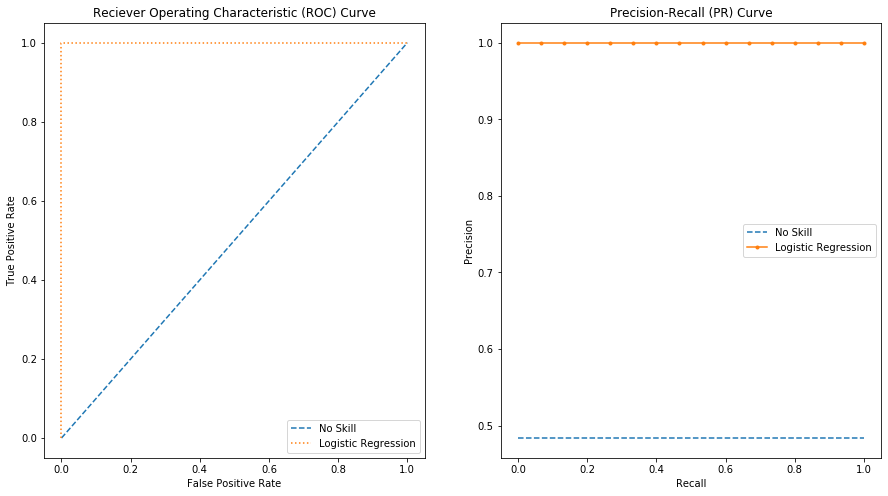

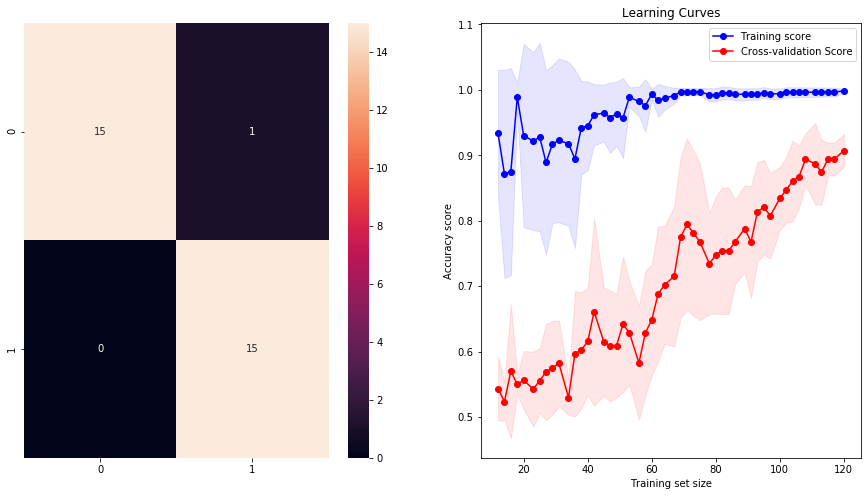

In [9]:
modelEval(X,y,'Logistic Regression')

## Checking regularization model improvements: comparing learning curves

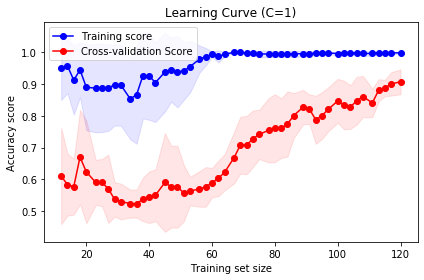

In [10]:
learning_curves(X,y)

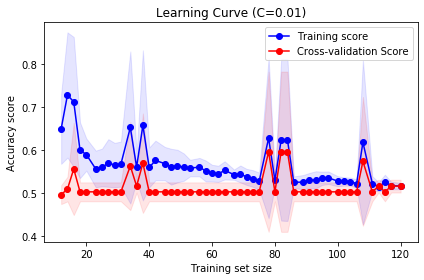

In [11]:
learning_curves(X,y, 0.01)

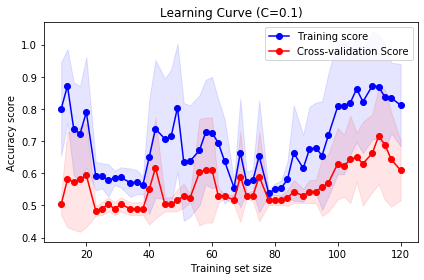

In [12]:
learning_curves(X,y, 0.1)

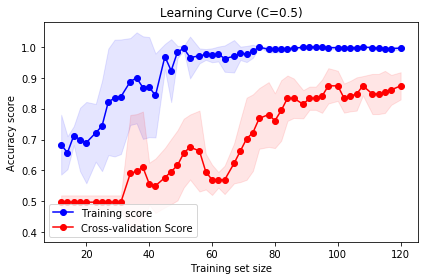

In [13]:
learning_curves(X,y, 0.5)

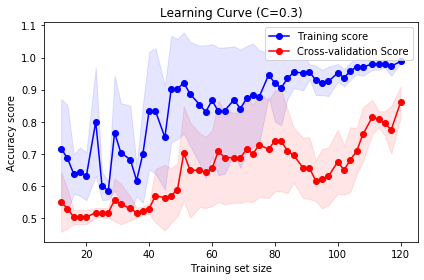

In [14]:
learning_curves(X,y, 0.3)

model accuracy:  0.967741935483871
model precision:  0.9375
model recall:  1.0
model f1:  0.967741935483871
AUC score:  1.0


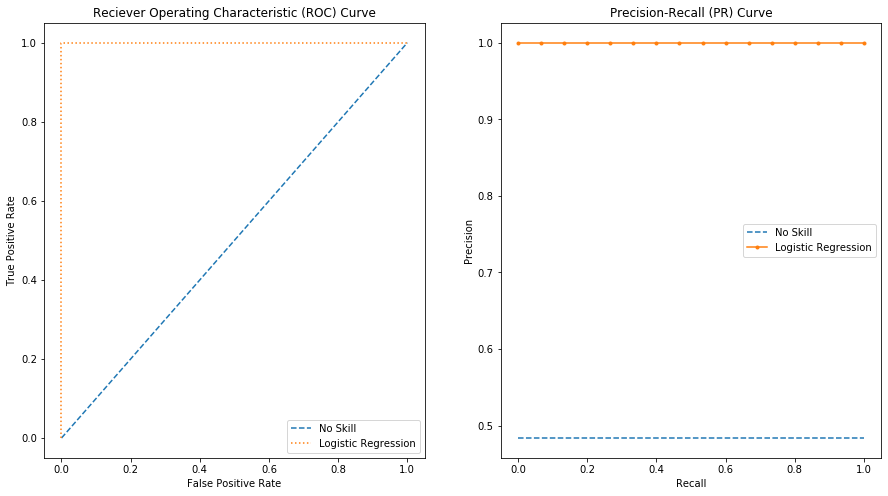

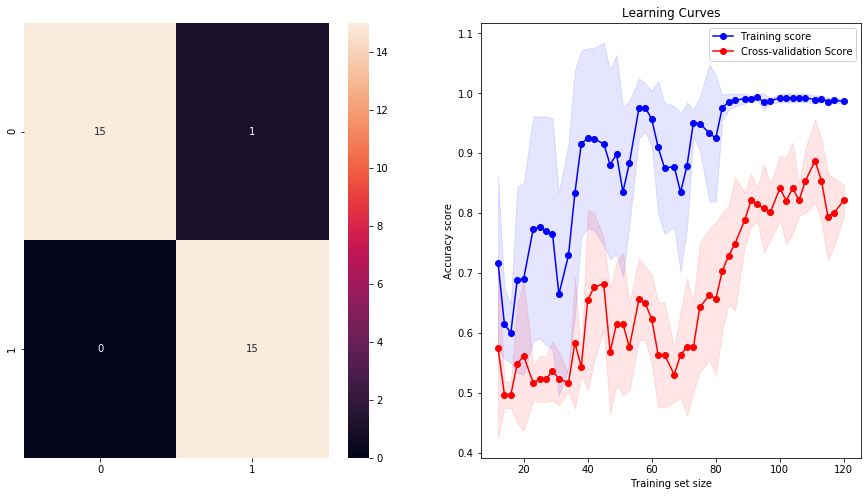

In [15]:
modelEval(X,y,'Logistic Regression', 0.3)